Code for "mixing" of class visualizations. See [this blogpost](http://auduno.com/post/125837418083/drawing-with-googlenet) for details.

Before running the code, insert your pycaffe path in ```pycaffe_root``` and insert the path to the googlenet model in ```model_path```. Download the bvlc googlenet model from [here](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet) if you haven't done so already.

In [1]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import os,re,random
import scipy.ndimage as nd
import PIL.Image
import sys,time,string
from IPython.display import clear_output, Image, display
from scipy.misc import imresize

pycaffe_root = "/your/path/here/caffe/python" # substitute your path here
sys.path.insert(0, pycaffe_root)
import caffe

model_name = "GoogLeNet"
model_path = '/your/path/here/caffe_models/bvlc_googlenet/' # substitute your path here
net_fn   = '../deploy_googlenet_updated.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'
mean = np.float32([104.0, 117.0, 123.0])

#caffe.set_mode_gpu() # uncomment this if gpu processing is available
net = caffe.Classifier(net_fn, param_fn,
                       mean = mean, # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def blur(img, sigma):
    if sigma > 0:
        img[0] = nd.filters.gaussian_filter(img[0], sigma, order=0)
        img[1] = nd.filters.gaussian_filter(img[1], sigma, order=0)
        img[2] = nd.filters.gaussian_filter(img[2], sigma, order=0)
    return img

def showarray(a, f, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [6]:
def make_step(net, step_size=1.5, end='inception_4c/output', clip=True, focus=None, sigma=None):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob

    dst = net.blobs[end]
    net.forward(end=end)

    one_hot = np.zeros_like(dst.data)
    one_hot.flat[focus] = 1.
    dst.diff[:] = one_hot

    net.backward(start=end)
    g = src.diff[0]
    
    src.data[:] += step_size/np.abs(g).mean() * g

    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias) 
        
    src.data[0] = blur(src.data[0], sigma)
    
    dst.diff.fill(0.)
    
def deepdraw(net, base_img, octaves, focus, visualize=True, clip=True):
    
    # prepare base image
    image = preprocess(net, base_img) # (3,224,224)
    
    # get input dimensions from net
    w = net.blobs['data'].width
    h = net.blobs['data'].height
    
    print "starting drawing"
    src = net.blobs['data']
    src.reshape(1,3,h,w) # resize the network's input image size
    current_scale = 1.0
    for e,o in enumerate(octaves):
        if 'scale' in o:
            # resize by o['scale'] if it exists
            image = nd.zoom(image, (1,o['scale'],o['scale']))
            current_scale *= o['scale']
        _,imw,imh = image.shape
        
        # select layer
        layer = o['layer']

        for i in xrange(o['iter_n']):
            for f in focus.keys():
                # randomly select a 224x224 crop centered on midpoint
                mid_x = focus[f][1]*current_scale - 224/2
                mid_y = focus[f][0]*current_scale - 224/2
                width = max((224*current_scale)-224,10.)
                ox = np.random.normal(mid_x, width*0.3, 1)
                ox = int(np.clip(ox,0,imw-224))
                oy = np.random.normal(mid_y, width*0.3, 1)
                oy = int(np.clip(oy,0,imw-224))
                
                # insert the crop into src.data[0]
                src.data[0] = image[:,ox:ox+224,oy:oy+224]

                sigma = o['start_sigma'] + ((o['end_sigma'] - o['start_sigma']) * i) / o['iter_n']
                step_size = o['start_step_size'] + ((o['end_step_size'] - o['start_step_size']) * i) / o['iter_n']

                make_step(net, end=layer, clip=clip, focus=f, sigma=sigma, step_size=step_size)

                if visualize:
                    vis = deprocess(net, src.data[0])
                    if not clip: # adjust image contrast if clipping is disabled
                        vis = vis*(255.0/np.percentile(vis, 99.98))
                    showarray(vis,"./filename"+str(i)+".jpg")
                
                if i > 0 and i % 10 == 0:
                    print 'finished step %d in octave %d for focus %d' % (i,e,f)

                # insert modified image into image
                image[:,ox:ox+224,oy:oy+224] = src.data[0]
        
        print "octave %d image:" % e
        showarray(deprocess(net, image),"./octave_"+str(e)+".jpg")
            
    # returning the resulting image
    return deprocess(net, image)

Define the dimension of the final image via ```start_dim```, then define which classes and where to draw them via ```focus```.

starting drawing
finished step 10 in octave 0 for focus 368
finished step 10 in octave 0 for focus 735
finished step 20 in octave 0 for focus 368
finished step 20 in octave 0 for focus 735
finished step 30 in octave 0 for focus 368
finished step 30 in octave 0 for focus 735
finished step 40 in octave 0 for focus 368
finished step 40 in octave 0 for focus 735
finished step 50 in octave 0 for focus 368
finished step 50 in octave 0 for focus 735
finished step 60 in octave 0 for focus 368
finished step 60 in octave 0 for focus 735
finished step 70 in octave 0 for focus 368
finished step 70 in octave 0 for focus 735
finished step 80 in octave 0 for focus 368
finished step 80 in octave 0 for focus 735
finished step 90 in octave 0 for focus 368
finished step 90 in octave 0 for focus 735
finished step 100 in octave 0 for focus 368
finished step 100 in octave 0 for focus 735
finished step 110 in octave 0 for focus 368
finished step 110 in octave 0 for focus 735
finished step 120 in octave 0 for

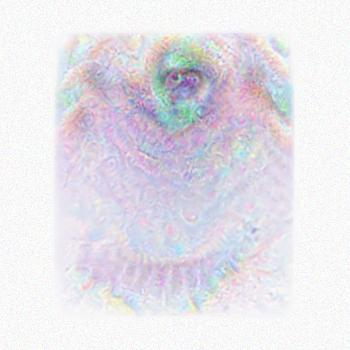

finished step 10 in octave 1 for focus 368
finished step 10 in octave 1 for focus 735
finished step 20 in octave 1 for focus 368
finished step 20 in octave 1 for focus 735
finished step 30 in octave 1 for focus 368
finished step 30 in octave 1 for focus 735
finished step 40 in octave 1 for focus 368
finished step 40 in octave 1 for focus 735
finished step 50 in octave 1 for focus 368
finished step 50 in octave 1 for focus 735
finished step 60 in octave 1 for focus 368
finished step 60 in octave 1 for focus 735
finished step 70 in octave 1 for focus 368
finished step 70 in octave 1 for focus 735
finished step 80 in octave 1 for focus 368
finished step 80 in octave 1 for focus 735
finished step 90 in octave 1 for focus 368
finished step 90 in octave 1 for focus 735
finished step 100 in octave 1 for focus 368
finished step 100 in octave 1 for focus 735
finished step 110 in octave 1 for focus 368
finished step 110 in octave 1 for focus 735
finished step 120 in octave 1 for focus 368
finish

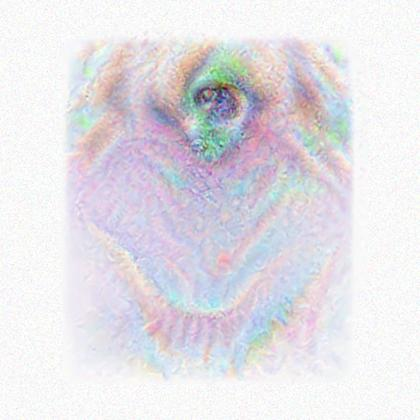

finished step 10 in octave 2 for focus 368
finished step 10 in octave 2 for focus 735
finished step 20 in octave 2 for focus 368
finished step 20 in octave 2 for focus 735
finished step 30 in octave 2 for focus 368
finished step 30 in octave 2 for focus 735
finished step 40 in octave 2 for focus 368
finished step 40 in octave 2 for focus 735
finished step 50 in octave 2 for focus 368
finished step 50 in octave 2 for focus 735
finished step 60 in octave 2 for focus 368
finished step 60 in octave 2 for focus 735
finished step 70 in octave 2 for focus 368
finished step 70 in octave 2 for focus 735
finished step 80 in octave 2 for focus 368
finished step 80 in octave 2 for focus 735
finished step 90 in octave 2 for focus 368
finished step 90 in octave 2 for focus 735
finished step 100 in octave 2 for focus 368
finished step 100 in octave 2 for focus 735
finished step 110 in octave 2 for focus 368
finished step 110 in octave 2 for focus 735
finished step 120 in octave 2 for focus 368
finish

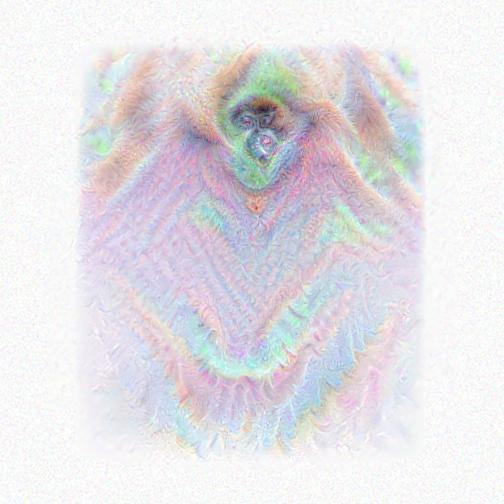

octave 3 image:


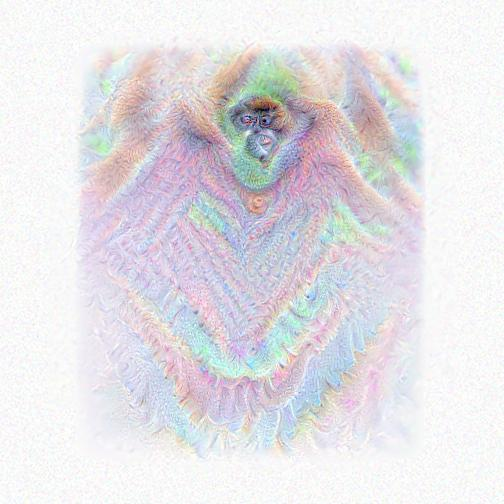

it took 1645.976236 seconds


In [9]:
octaves = [
    {
        'layer':'loss3/classifier',
        'iter_n':190,
        'start_sigma':2.5,
        'end_sigma':0.78,
        'start_step_size':6.,
        'end_step_size':6.
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.78,
        'start_step_size':6.,
        'end_step_size':6.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.44,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss1/classifier',
        'scale':1.0,
        'iter_n':10,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    }
]

start_dim = [350,350] # dimension of the picture we generate

# mix of gibbon and poncho
focus = {
    735 : [175,200], # which class (key) and where to draw it (coordinates)
    368 : [175,150],
}

background_color = np.float32([250.0, 250.0, 250.0])
gen_image = np.random.normal(background_color, 8, (start_dim[0], start_dim[1], 3))

starttime = time.time()
gen_image = deepdraw(net, gen_image, octaves, focus, visualize=False)
print "it took %f seconds" % (time.time()-starttime)

# save image
#focs = [str(k) for k in focus.keys()]
#foc_fname = string.join(focs,"_")
#img_fn = '_'.join([model_name, "deepdraw_mixing_classes", foc_fname+'.png'])
#PIL.Image.fromarray(np.uint8(gen_image)).save('./' + img_fn)

starting drawing
finished step 10 in octave 0 for focus 366
finished step 10 in octave 0 for focus 566
finished step 20 in octave 0 for focus 366
finished step 20 in octave 0 for focus 566
finished step 30 in octave 0 for focus 366
finished step 30 in octave 0 for focus 566
finished step 40 in octave 0 for focus 366
finished step 40 in octave 0 for focus 566
finished step 50 in octave 0 for focus 366
finished step 50 in octave 0 for focus 566
finished step 60 in octave 0 for focus 366
finished step 60 in octave 0 for focus 566
finished step 70 in octave 0 for focus 366
finished step 70 in octave 0 for focus 566
finished step 80 in octave 0 for focus 366
finished step 80 in octave 0 for focus 566
finished step 90 in octave 0 for focus 366
finished step 90 in octave 0 for focus 566
finished step 100 in octave 0 for focus 366
finished step 100 in octave 0 for focus 566
finished step 110 in octave 0 for focus 366
finished step 110 in octave 0 for focus 566
finished step 120 in octave 0 for

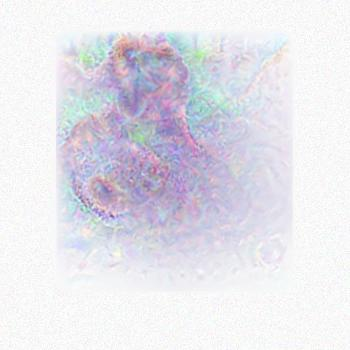

finished step 10 in octave 1 for focus 366
finished step 10 in octave 1 for focus 566
finished step 20 in octave 1 for focus 366
finished step 20 in octave 1 for focus 566
finished step 30 in octave 1 for focus 366
finished step 30 in octave 1 for focus 566
finished step 40 in octave 1 for focus 366
finished step 40 in octave 1 for focus 566
finished step 50 in octave 1 for focus 366
finished step 50 in octave 1 for focus 566
finished step 60 in octave 1 for focus 366
finished step 60 in octave 1 for focus 566
finished step 70 in octave 1 for focus 366
finished step 70 in octave 1 for focus 566
finished step 80 in octave 1 for focus 366
finished step 80 in octave 1 for focus 566
finished step 90 in octave 1 for focus 366
finished step 90 in octave 1 for focus 566
finished step 100 in octave 1 for focus 366
finished step 100 in octave 1 for focus 566
finished step 110 in octave 1 for focus 366
finished step 110 in octave 1 for focus 566
finished step 120 in octave 1 for focus 366
finish

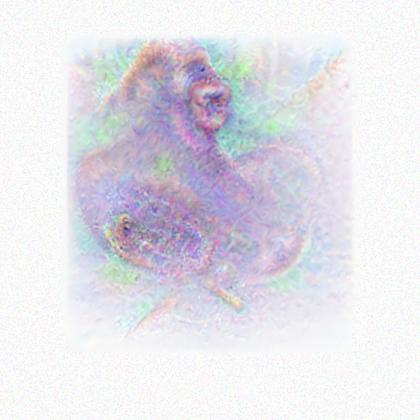

finished step 10 in octave 2 for focus 366
finished step 10 in octave 2 for focus 566
finished step 20 in octave 2 for focus 366
finished step 20 in octave 2 for focus 566
finished step 30 in octave 2 for focus 366
finished step 30 in octave 2 for focus 566
finished step 40 in octave 2 for focus 366
finished step 40 in octave 2 for focus 566
finished step 50 in octave 2 for focus 366
finished step 50 in octave 2 for focus 566
finished step 60 in octave 2 for focus 366
finished step 60 in octave 2 for focus 566
finished step 70 in octave 2 for focus 366
finished step 70 in octave 2 for focus 566
finished step 80 in octave 2 for focus 366
finished step 80 in octave 2 for focus 566
finished step 90 in octave 2 for focus 366
finished step 90 in octave 2 for focus 566
finished step 100 in octave 2 for focus 366
finished step 100 in octave 2 for focus 566
finished step 110 in octave 2 for focus 366
finished step 110 in octave 2 for focus 566
finished step 120 in octave 2 for focus 366
finish

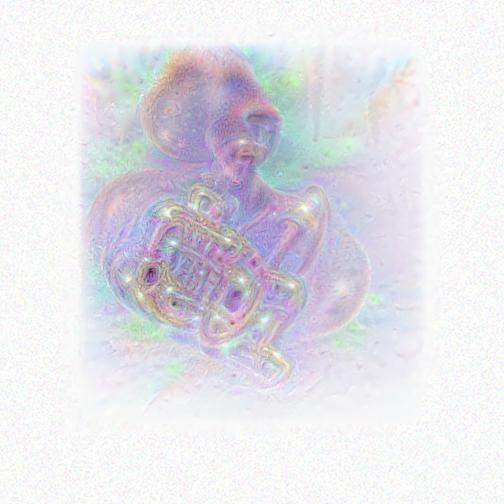

octave 3 image:


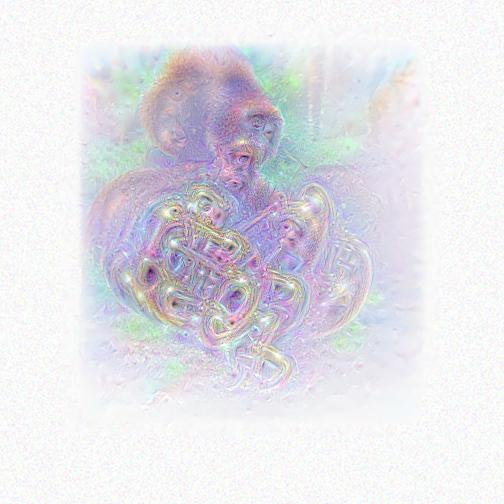

it took 1662.458674 seconds


In [8]:
# mix of gorilla and french horn
focus = {
    566 : [175,175],
    366 : [175,150]
}

gen_image = np.random.normal(background_color, 8, (start_dim[0], start_dim[1], 3))
starttime = time.time()
gen_image = deepdraw(net, gen_image, octaves, focus, visualize=False)
print "it took %f seconds" % (time.time()-starttime)

# save image
#focs = [str(k) for k in focus.keys()]
#foc_fname = string.join(focs,"_")
#img_fn = '_'.join([model_name, "deepdraw_mixing_classes", foc_fname+'.png'])
#PIL.Image.fromarray(np.uint8(gen_image)).save('./' + img_fn)